In [4]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from modules import *

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 459 to 932
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WAP                474 non-null    float64
 1   seconds_in_bucket  474 non-null    int64  
 2   log_return         473 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 14.8 KB


<Axes: >

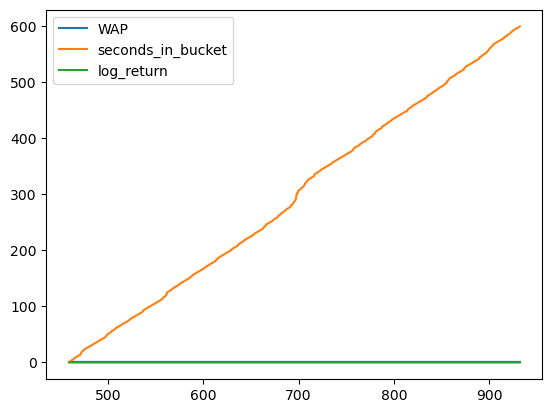

In [16]:
df = pd.read_csv("./individual_book_train/stock_10.csv")
df['WAP'] = (df['bid_price1']*df['ask_size1'] + df['ask_price1']*df['bid_size1']) /\
    (df['bid_size1'] + df['ask_size1'])
df_filtered = df[df['time_id'] == 11][['WAP','seconds_in_bucket']]

df_filtered = calculate_log_returns(df_filtered)

df_filtered.info()
df_filtered.plot()

define training and testing data

In [17]:
df_train = df_filtered.loc[(df_filtered['seconds_in_bucket'] < 400)]
df_test = df_filtered.loc[df_filtered['seconds_in_bucket'] >= 400]
actual_volatility = calculate_volatility(np.array(df_test['log_return']))
print(actual_volatility)

0.0012146495993907082


check for stationary

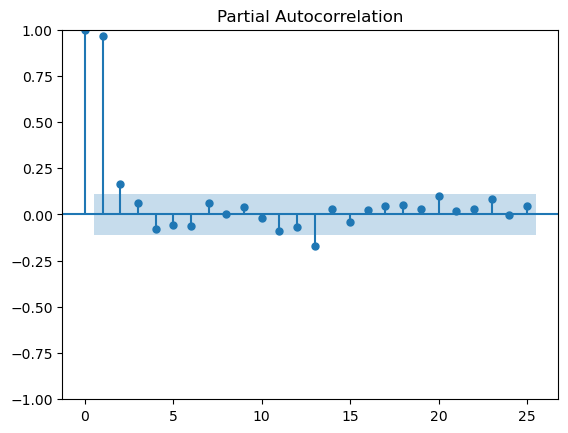

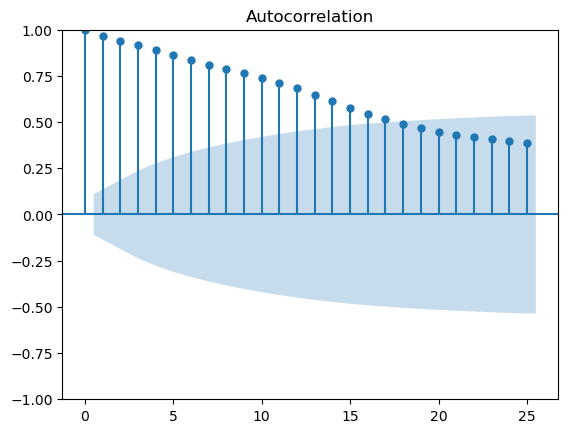

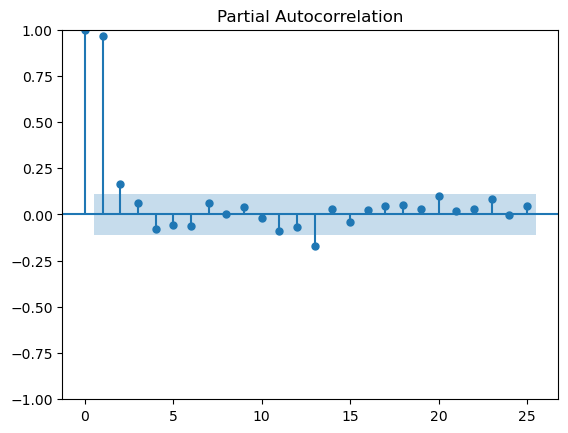

In [7]:
plot_acf(df_train['log_return'])
plot_pacf(df_train['log_return'])

ADF Test

In [8]:
adf_test = adfuller(df_train['WAP'])
print(f'p-value: {adf_test[1]}')

p-value: 0.31914498592800866


The large p-value means the test fails to rejct the null hypothesis, suggesting the time series is non-stationary

Use differencing to transform data to stationary.

<Axes: >

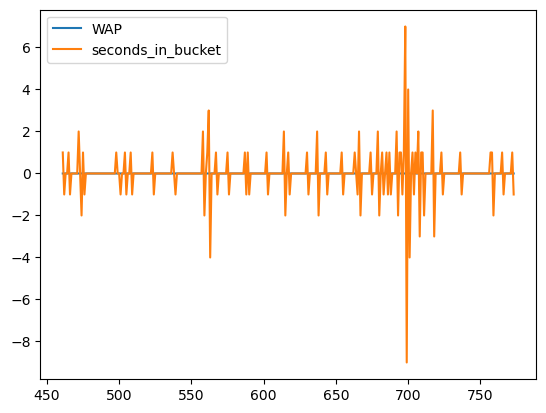

In [9]:
df_train_diff = df_train.diff().diff().dropna()
df_train_diff.plot()

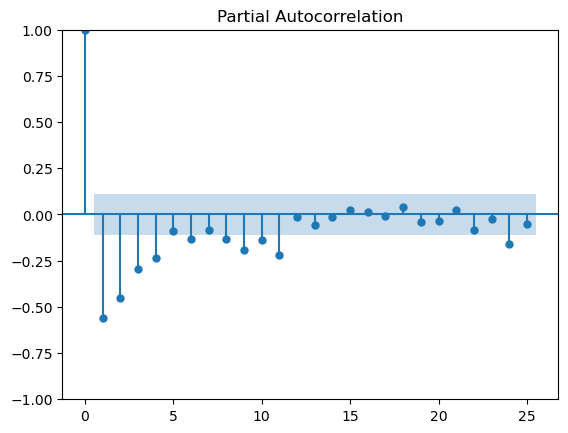

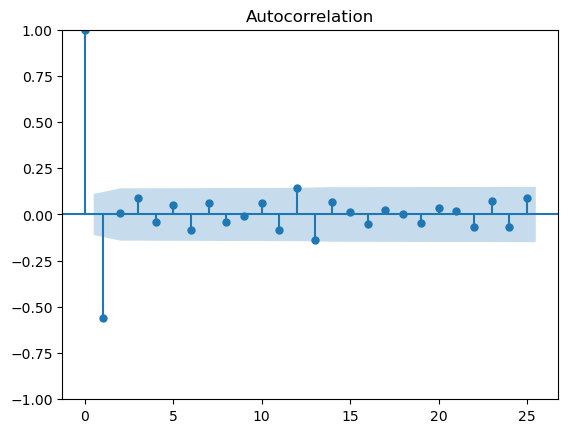

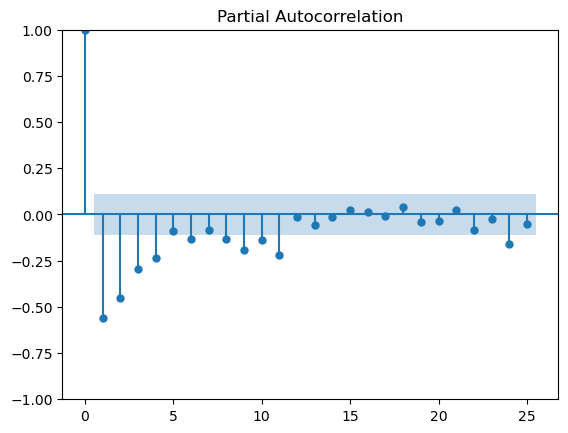

In [10]:
plot_acf(df_train_diff['WAP'])
plot_pacf(df_train_diff['WAP'])

In [11]:
adf_test_diff = adfuller(df_train_diff['WAP'])
print(f'p-value: {adf_test_diff[1]}')

p-value: 4.357951361711993e-20


Therefore the paramater d = 1

Fit the ARIMA model

In [12]:
model = ARIMA(df_train['WAP'], order = (2,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    WAP   No. Observations:                  315
Model:                 ARIMA(2, 2, 1)   Log Likelihood                2378.272
Date:                Thu, 25 Apr 2024   AIC                          -4748.545
Time:                        16:17:24   BIC                          -4733.560
Sample:                             0   HQIC                         -4742.557
                                - 315                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2961   3.41e-18   -8.7e+16      0.000      -0.296      -0.296
ar.L2         -0.1591    1.3e-18  -1.22e+17      0.000      -0.159      -0.159
ma.L1         -0.6527   4.41e-18  -1.48e+17      0.0

/Users/mia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


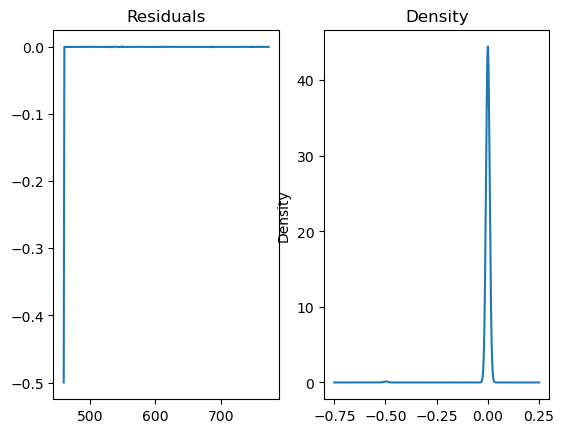

In [13]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

Plot for prediction.

In [14]:
forecast_test = model_fit.forecast(200)
df_filtered_log['forecast'] = [None]*len(df_train) + list(forecast_test)
df_filtered_log.plot()

/Users/mia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


NameError: name 'df_filtered_log' is not defined

Auto-fit the ARIMA model

In [ ]:
auto_arima = pm.auto_arima(df_train, stepwise = False, seasonal = False)
auto_arima.summary()

Resulting a different ARIMA model ARMIA(0,1,1) where the graph above shows the prediction for ARIMA(2,1,0).

In [ ]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
mae210 = mean_absolute_error(df_test, forecast_test)
mape210 = mean_absolute_percentage_error(df_test, forecast_test)
rmse210 = np.sqrt(mean_squared_error(df_test, forecast_test))

mae011 = mean_absolute_error(df_test, forecast_test_auto)
mape011 = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse011 = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'Mean Absolute Error - manual: {mae210}')
print(f'Mean Absolute Error - auto: {mae011}')
print(f'Mean Absolute Percentage Error - manual: {mape210}')
print(f'Mean Absolute Percentage Error - auto: {mape011}')
print(f'Mean Aquared Error - manual: {rmse210}')
print(f'Mean Aquared Error - auto: {rmse011}')